In [66]:
import glob
import time
import numpy as np
import pandas as pd
from pprint import pprint
from math import log10, sqrt

# Visualization libraries
import matplotlib.pyplot as plt

# Machine/Deep Learning related libraries
import tensorflow as tf
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from skimage.metrics import structural_similarity as ssim

In [3]:
# Loading xlines 2D sections from npz files
P_i1041 = np.load('/appdrive/Penobscot_i1041.npz')['arr_0']
P_i1081 = np.load('/appdrive/Penobscot_i1081.npz')['arr_0']
P_i1121 = np.load('/appdrive/Penobscot_i1121.npz')['arr_0']

In [4]:
P_i1041.shape, P_i1081.shape, P_i1121.shape

((40, 482, 61, 1501), (40, 482, 61, 1501), (40, 482, 61, 1501))

## Baseline Linear Regression

In [5]:
# Limiting color display range
vmax = np.percentile(P_i1121, 99)

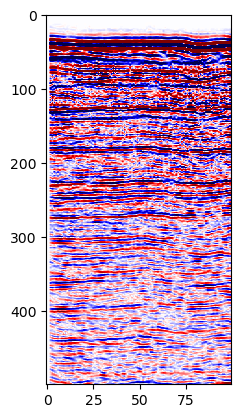

In [6]:
plt.imshow(P_i1121[-1, :100, 0, :500].T, aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.show()

In [10]:
# Data Masking
data = P_i1081[-1, :100, 0, :500]
left = np.ones(40)

In [11]:
data.shape

(100, 500)

In [12]:
data = data.T
middle = np.zeros(20)
single_layer = np.hstack((np.hstack((left, middle)), left))
mask = np.tile(single_layer, (data.shape[0], 1))
mask.shape

(500, 100)

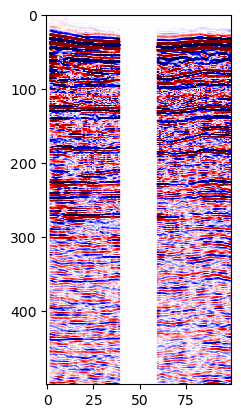

In [13]:
# X masking
x_masked = data*mask
plt.imshow(x_masked, aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.show()

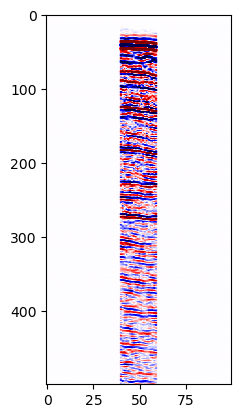

In [14]:
# Y Masking
y_left = np.zeros(40)
y_middle = np.ones(20)
single_y_layer = np.hstack((np.hstack((y_left, y_middle)), y_left))
y_mask = np.tile(single_y_layer, (data.shape[0], 1))
y_masked = data*y_mask
plt.imshow(y_masked, aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.show()

### Baseline Modelling

In [24]:
x_masked.shape, y_masked.shape

((500, 100), (500, 100))

In [25]:
#train-test split
x_train = x_masked[:400]
y_train = y_masked[:400]
x_test = x_masked[401:]
y_test = y_masked[401:]

In [26]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Mean squared error: 466267.09
Coefficient of determination: 0.67


In [42]:
type(y_pred)

numpy.ndarray

In [46]:
diff = ssim(y_test, y_pred, data_range=y_pred.max() - y_pred.min())
print("Image similarity", diff)

Image similarity 0.758144247485443


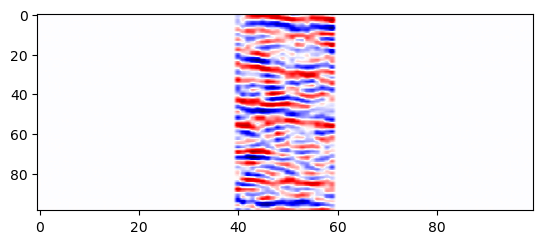

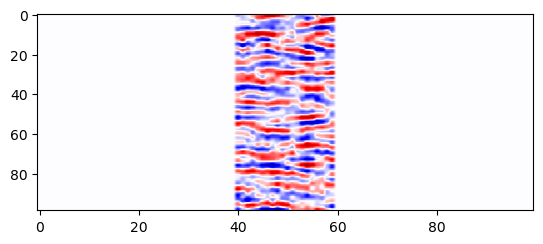

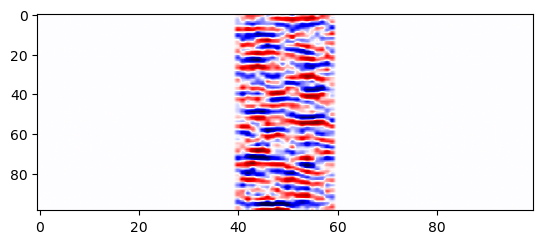

In [33]:
plt.imshow(y_test, aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.show()

plt.imshow(y_pred, aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.show()

plt.imshow(y_test-y_pred, aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.show()

In [51]:
y_test[:, 41].shape, np.arange(1, 100).shape

((99,), (99,))

In [70]:
y_test.shape

(99, 100)

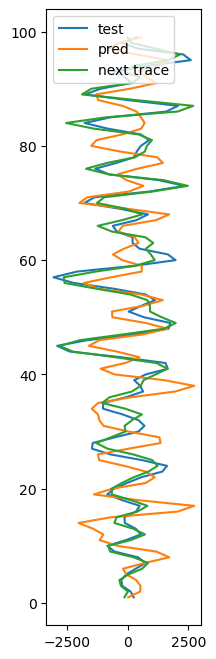

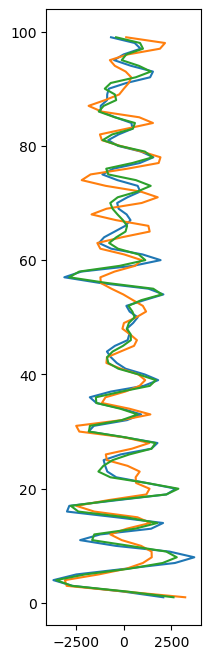

In [74]:
# Comparing traces at edge of missing intervals
trace_no = 41
plt.figure(figsize=(2, 8))
plt.plot(y_test[:, trace_no], np.arange(1, 100), label='test')
plt.plot(y_pred[:, trace_no], np.arange(1, 100), label='pred')
plt.plot(P_i1081[-2, trace_no, 0, 401:500].T, np.arange(1, 100), label='next trace')
plt.legend(loc='best')

plt.show()

trace_no = 59
plt.figure(figsize=(2, 8))
plt.plot(y_test[:, trace_no], np.arange(1, 100))
plt.plot(y_pred[:, trace_no], np.arange(1, 100))
plt.plot(P_i1081[-2, trace_no, 0, 401:500].T, np.arange(1, 100), label='next trace')
plt.legend(loc='best')
plt.show()

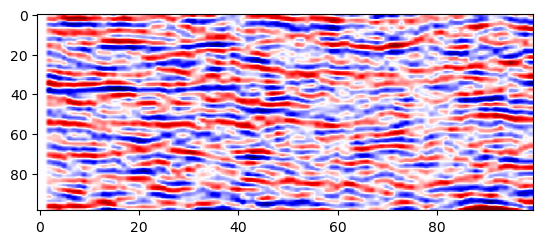

In [28]:
# Combining x_test and y_test
test_result =  x_test + y_test
plt.imshow(test_result, aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.show()

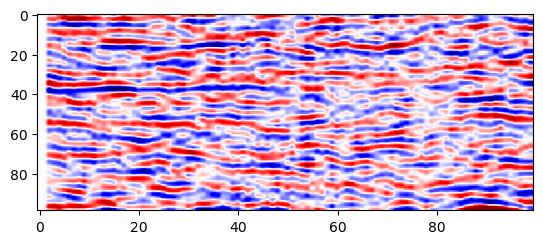

In [29]:
pred_result =  x_test + y_pred
plt.imshow(pred_result, aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.show()

In [47]:
diff = ssim(test_result, pred_result, data_range=y_pred.max() - y_pred.min())
print("Image similarity", diff)

Image similarity 0.7862984655478236


## Baseline CNN

### Patching Dataset

In [15]:
# Dividing sections into 5 patches and crop the twt to 512 samples
compiled = []
hor = 96
start = 0
for i in range(start, 480, hor):
    data = P_i1121[:, i:i+hor, 0, :512]
    compiled.append(data)
    
compiled = np.array(compiled)
compiled.shape

(5, 40, 96, 512)

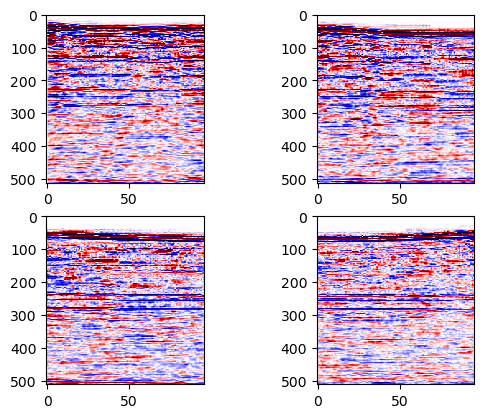

<Figure size 2400x2400 with 0 Axes>

In [16]:
f, axarr = plt.subplots(2,2)
plt.figure(figsize=(24, 24))
axarr[0,0].imshow(compiled[0, 0].T, aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[0,1].imshow(compiled[1, 0].T, aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[1,0].imshow(compiled[2, 0].T, aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[1,1].imshow(compiled[3, 0].T, aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.tight_layout()
plt.show()

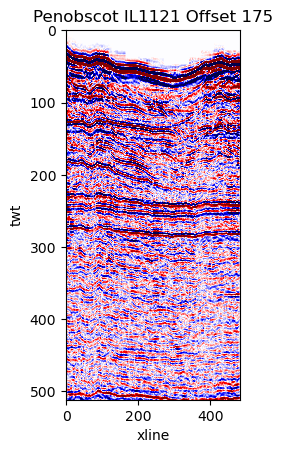

In [124]:
plt.imshow(P_i1121[0, :, 0, :512].T, aspect=2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.xlabel('xline')
plt.ylabel('twt')
plt.title('Penobscot IL1121 Offset 175')
plt.show()

In [21]:
# Swap the axes
patched = compiled.reshape(compiled.shape[0]*compiled.shape[1], compiled.shape[2], compiled.shape[-1])
patched = np.swapaxes(patched, 1, -1)
patched.shape

(200, 512, 96)

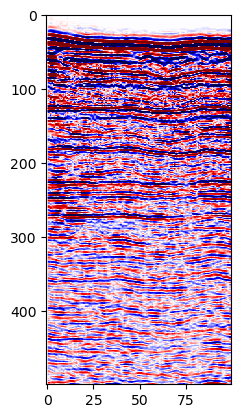

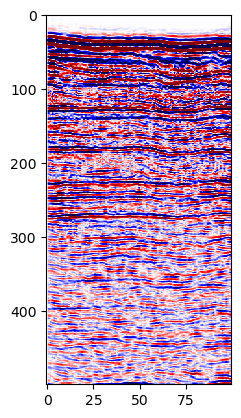

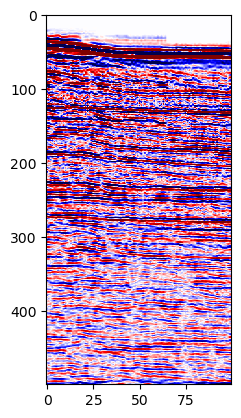

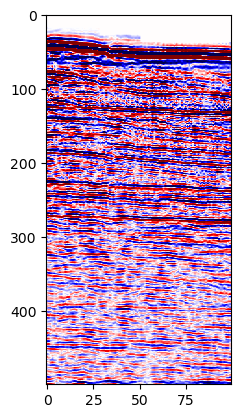

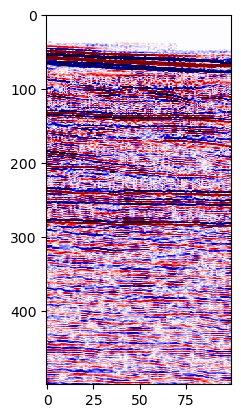

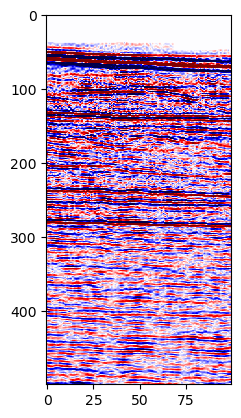

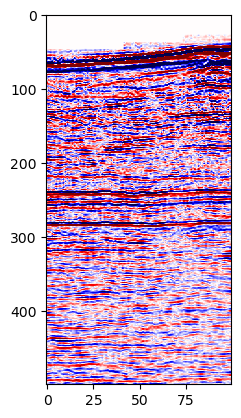

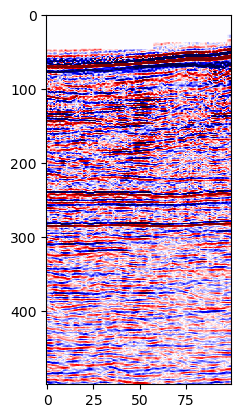

In [125]:
for i in range(0, 160, 20):
    plt.imshow(patched[i], aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
    plt.show()

### Masking

In [205]:
# No. of samples for missing interval
n_samples = 40
distance = n_samples*25

# X Masking
left = np.ones((96-n_samples)//2) #28, 38, 43
middle = np.zeros(n_samples)
single_layer = np.hstack((np.hstack((left, middle)), left))
mask = np.tile(single_layer, (patched.shape[1], 1))

x1_mask = np.repeat(np.expand_dims(mask, 0), patched.shape[0], axis=0)
x1_mask.shape

(200, 512, 96)

In [206]:
x1_mask[0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Text(0.5, 0.98, 'Original')

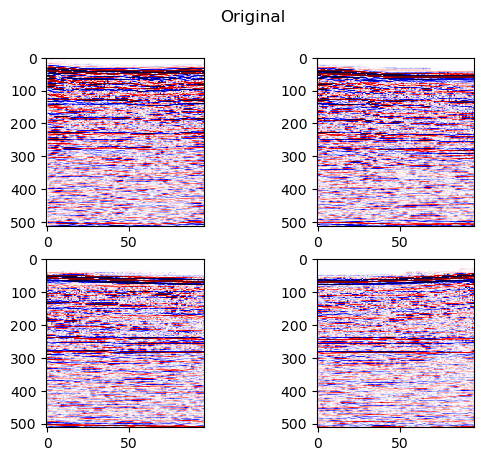

In [207]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(patched[0], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[0,1].imshow(patched[40], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[1,0].imshow(patched[80], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[1,1].imshow(patched[120], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
f.suptitle('Original')

Text(0.5, 0.98, 'Masked - 1000 m interval (40 samples)')

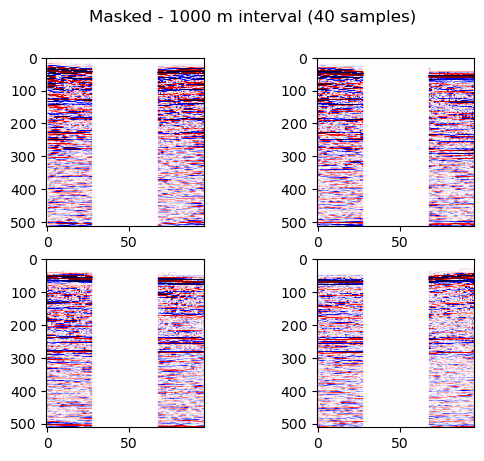

In [208]:
x1_data = patched*x1_mask
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x1_data[0], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[0,1].imshow(x1_data[40], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[1,0].imshow(x1_data[80], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[1,1].imshow(x1_data[120], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
f.suptitle(f'Masked - {distance} m interval ({n_samples} samples)')

In [209]:
# Y Masking
y1_mask = 1-x1_mask
y1_mask.shape

(200, 512, 96)

Text(0.5, 0.98, 'Ground Truth - 1000 m interval (40 samples)')

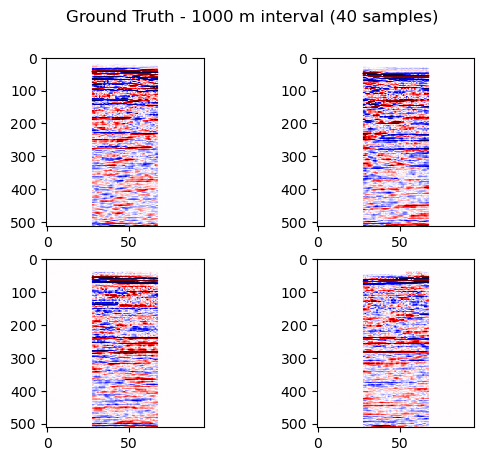

In [210]:
y1_data = patched*y1_mask
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(y1_data[0], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[0,1].imshow(y1_data[40], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[1,0].imshow(y1_data[80], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
axarr[1,1].imshow(y1_data[120], aspect=0.2, cmap='seismic_r', vmin=-vmax, vmax=vmax)
f.suptitle(f'Ground Truth - {distance} m interval ({n_samples} samples)')

def scaling(data):
    return data/4000

In [211]:
# Train-test split
x1_train, x1_test, y1_train, y1_test = train_test_split(x1_data, y1_data, test_size=0.33, random_state=42)
x1_train = np.expand_dims(x1_train, -1)
x1_test = np.expand_dims(x1_test, -1)
y1_train = np.expand_dims(y1_train, -1)
y1_test = np.expand_dims(y1_test, -1)
input_shapes=x1_train.shape[1:]
input_shapes

(512, 96, 1)

x1_train = scaling(x1_train)
x1_test = scaling(x1_test)
y1_train = scaling(y1_train)
y1_test = scaling(y1_test)

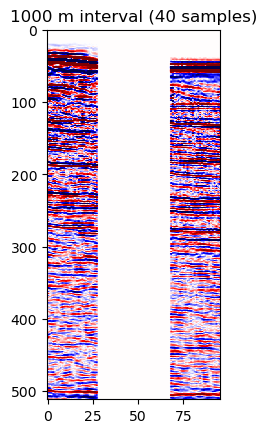

In [212]:
plt.imshow(x1_train[0, :, :, 0], aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.title(f'{distance} m interval ({n_samples} samples)')
plt.show()

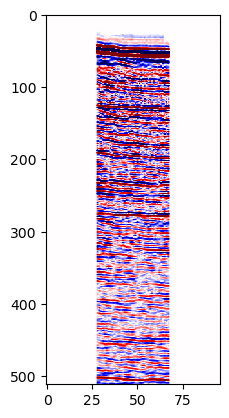

In [213]:
plt.imshow(y1_train[0, :, :, 0], aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
# plt.title(f'Ground Truth')
plt.show()

### Modelling

In [214]:
def cnn2d(input_shapes=input_shapes, n_outputs=10):
     
    filters = [8, 16, 32, 64, 128]
    kernel_size = [(3, 3)]
    
    inputs = tf.keras.layers.Input(shape=input_shapes, name='input')
    
    
    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    for i in range(1, len(filters)):
        x = tf.keras.layers.Conv2D(filters=filters[i], kernel_size=kernel_size[0], padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dropout(0.1)(x)     
        x = tf.keras.layers.MaxPooling2D()(x)
#     x = tf.keras.layers.Dropout(0.2 , name='dropout_1')(x)
    
    for i in range(len(filters), 1, -1):
        x = tf.keras.layers.UpSampling2D()(x)    
        x = tf.keras.layers.Conv2DTranspose(filters=filters[i-1], kernel_size=kernel_size[0], padding='same')(x)
        
    x = tf.keras.layers.UpSampling2D()(x) 
    outputs = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size[0], padding='same')(x)
    
    # outputs = tf.keras.layers.Dense(n_outputs, name='output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="cnn2D_model")
    
    optimizer = tf.keras.optimizers.Adam(0.005)

    model.compile(loss='mse',  
        optimizer=optimizer,
        metrics=['mae', 'mse']) 
    return model

In [215]:
t0 = time.perf_counter()
EPOCHS = 700 # number of iterations

# To print out epochs at every EPOCH/5 steps
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % (EPOCHS/5) == 0:
            print(f'{epoch}/{EPOCHS} completed.')
    

callback_list = [CustomCallback()]
model = cnn2d()
model.summary()
history = model.fit(x1_train, y1_train, epochs=EPOCHS, batch_size=24, verbose=0, callbacks=callback_list) 

t1 = time.perf_counter() - t0
print('[INFO]: Training GPU elapsed time {:6.4f}'.format(t1))

Model: "cnn2D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512, 96, 1)]      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 512, 96, 8)        80        
                                                                 
 batch_normalization_20 (Bat  (None, 512, 96, 8)       32        
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 512, 96, 8)        0         
                                                                 
 dropout_20 (Dropout)        (None, 512, 96, 8)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 256, 48, 8)       0         
 g2D)                                                  

2022-11-27 05:12:49.706580: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incnn2D_model/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/700 completed.
280/700 completed.
420/700 completed.
560/700 completed.
[INFO]: Training GPU elapsed time 176.6120


[]

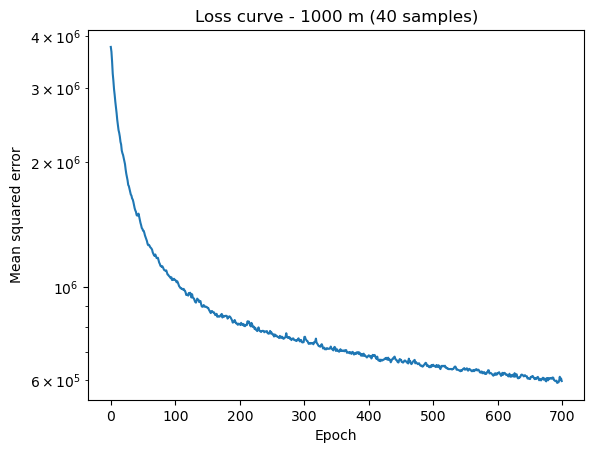

In [216]:
# Plotting loss curve
plt.plot(history.history['mse'])
plt.title(f'Loss curve - {distance} m ({n_samples} samples)')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.semilogy()

### Prediction

In [217]:
train_y1_pred = model.predict(x1_train)
train_y1_pred.shape

5/5 [==============================] - 0s 12ms/step


(134, 512, 96, 1)

In [218]:
test_y1_pred = model.predict(x1_test)
test_y1_pred.shape

3/3 [==============================] - 0s 11ms/step


(66, 512, 96, 1)

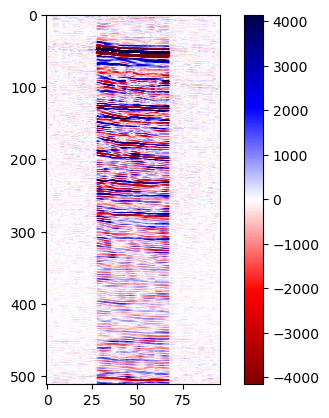

In [219]:
#train_y_prediction
plt.imshow(train_y1_pred[0, :, :, 0], aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

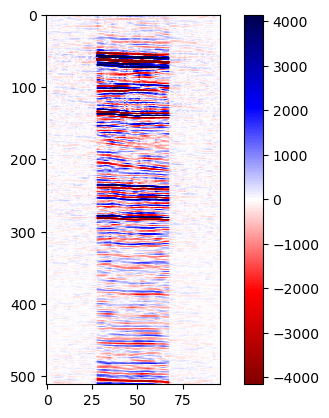

In [220]:
# test y prediction
plt.imshow(test_y1_pred[0, :, :, 0], aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

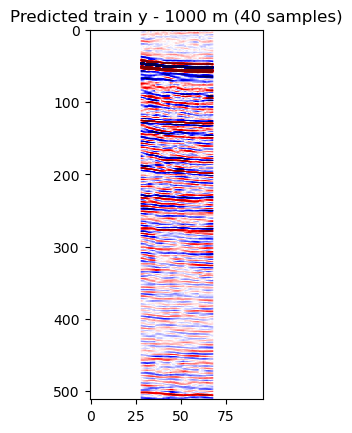

In [221]:
# Masking train_y_pred
test_y1_mask = np.expand_dims(y1_mask[:134], -1)
masked_train_y1_pred = train_y1_pred*test_y1_mask
plt.imshow(masked_train_y1_pred[0, :, :, 0], aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
# plt.colorbar()
plt.title(f'Predicted train y - {distance} m ({n_samples} samples)')
plt.show()

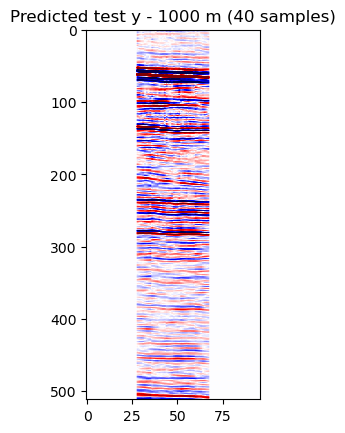

In [222]:
# Masking test_y_pred
test_y1_mask = np.expand_dims(y1_mask[:66], -1)
masked_y1_pred = test_y1_pred*test_y1_mask
plt.imshow(masked_y1_pred[0, :, :, 0], aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
# plt.colorbar()
plt.title(f'Predicted test y - {distance} m ({n_samples} samples)')
plt.show()

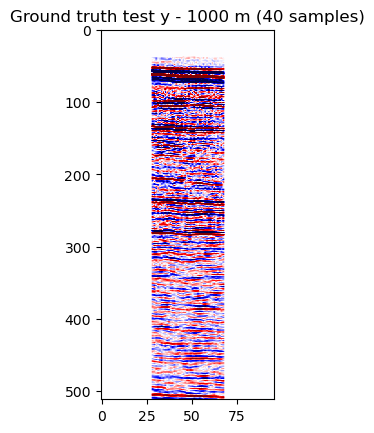

In [223]:
# Ground truth for test_y
plt.imshow(y1_test[0, :, :, 0], aspect=0.4, cmap='seismic_r', vmin=-vmax, vmax=vmax)
# plt.colorbar()
plt.title(f'Ground truth test y - {distance} m ({n_samples} samples)')
plt.show()

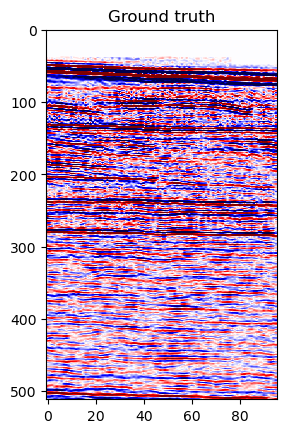

In [224]:
# Ground truth
test_result =  x1_test[0, :, :, 0] + y1_test[0, :, :, 0]
plt.imshow(test_result, aspect=0.3, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.title(f'Ground truth')
plt.show()

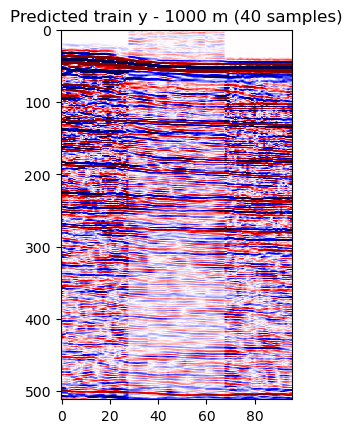

In [225]:
# Combining x_train and y_train_pred
pred_result =  x1_train[0, :, :, 0] + masked_train_y1_pred[0, :, :, 0]
plt.imshow(pred_result, aspect=0.3, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.title(f'Predicted train y - {distance} m ({n_samples} samples)')
plt.show()

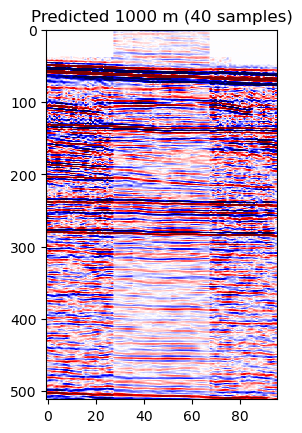

In [226]:
# Combining x_test and y_test_pred
pred_result =  x1_test[0, :, :, 0] + masked_y1_pred[0, :, :, 0]
plt.imshow(pred_result, aspect=0.3, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.title(f'Predicted {distance} m ({n_samples} samples)')
plt.show()

### Evaluation Metrics 

In [227]:
# Structural Similarilty Index (SSIM)
diff = ssim(masked_y1_pred[0, :, :, 0], y1_test[0, :, :, 0], data_range=y1_test[0, :, :, 0].max() - y1_test[0, :, :, 0].min())
print("Image similarity", diff)

Image similarity 0.8721070437478632


In [228]:
# Peak Signal-to-Noise ratio (PSNR)
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [229]:
PSNR(y1_test[0, :, :, 0], masked_y1_pred[0, :, :, 0])

-11.345593710524016